# 10. Syntax — Lab solutions

## Preparations

### Introduction

In this lab, we are going to use the [Python Natural Language Toolkit](http://www.nltk.org/) (`nltk`). It has an API that allows you to create, read, and parse with Context-free Grammars (CFG), as well as to convert parse trees to Chomsky Normal Form (CNF) and back and to display or pretty print them.

During the first few exercises, we are going to acquint ourselves with nltk using a toy grammar. In the second part, you will be asked to implement the CKY algorithm and test it on a real world treebank.

### Infrastructure

For today's exercises, you will need the docker image again. Provided you have already downloaded it last time, you can start it by:

- `docker ps -a`: lists all the containers you have created. Pick the one you used last time (with any luck, there is only one)
- `docker start <container id>`
- `docker exec -it <container id> bash`

In order to be able to run today's exercises, you will have to install some system- and Python packages as well.

```bash
apt-get install python3-tk
pip install graphviz
```

When that's done, update your git repository:

```bash
cd /nlp/python_nlp_2018_spring/
git pull
```

And start the notebook:
```
jupyter notebook --port=9999 --ip=0.0.0.0 --no-browser --allow-root
```

### Boilerplate

The following code imports the packages we are going to use. It also defines a function that draws the parse trees with the [`Graphviz`](http://www.graphviz.org/) library. `nltk` _can_ display the trees, but it depends on Tcl, which doesn't work on a headless (GUI-less) system.

In [4]:
import graphviz
import nltk
from nltk import Nonterminal
from nltk.parse.generate import generate
from nltk.tree import Tree

def does_tcl_work():
    """Checks if Tcl is installed and works (e.g. it won't on a headless server)."""
    tree = nltk.tree.Tree('test', [])
    try:
        tree._repr_png_()
        return True
    except:
        return False

def draw_tree(tree):
    """Draws an NLTK parse tree via Graphviz."""
    def draw_tree_rec(curr_root, graph, last_node):
        node_id = str(int(last_node) + 1)
        for child in curr_root:
            if isinstance(child, nltk.tree.Tree):
                graph.node(node_id, child.label(), penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
                node_id = draw_tree_rec(child, graph, node_id)
            else:
                graph.node(node_id, child, penwidth='0')
                graph.edge(last_node, node_id, color='darkslategray3', style='bold')
        return str(int(node_id) + 1)
    
    graph = graphviz.Graph()
    graph.graph_attr['ranksep'] = '0.2'
    graph.node('0', tree.label(), penwidth='0')
    draw_tree_rec(tree, graph, '0')
    return graph._repr_svg_()

# Use Graphviz to draw the tree if the Tcl backend of nltk doesn't work
if not does_tcl_work():
    svg_formatter = get_ipython().display_formatter.formatters['image/svg+xml']
    svg_formatter.for_type(nltk.tree.Tree, draw_tree)
    # Delete the nltk drawing function, just to be sure
    if hasattr(Tree, '_repr_png_'):
        delattr(Tree, '_repr_png_')

### Disclaimer

NLTK is not the only NLP library for Python. [spaCy](https://spacy.io/) is "industrial-strength" library which, like NLTK, implements various NLP tools for multiple languages. However, it also supports neural network models (on the GPU as well) and it integrates word vectors. A comparison is [availabe here](https://spacy.io/usage/facts-figures). We teach NLTK in this course because it lends itself better to education and experimentation.

However, if you are doing serious NLP work, you should also consider spaCy. But not with the RAM constraints we have to deal with in the lab. :)

## Exercises

### 1. Get to know nltk

In this exercise, we are using the toy grammar from the lecture with a little modification so that it can handle ditransitives.

In [3]:
# fromstring() returns a CFG instance from a string
# Observe the two ways one can specify alternations in the grammar
# and how terminal symbols are specified
toy_grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pronoun | ProperNoun | Det Nominal
Nominal -> Nominal Noun
Nominal -> Noun
VP -> Verb | Verb PP | Verb NP | Verb NP PP | Verb NP NP | Verb NP NP PP
PP -> Preposition NP
Pronoun -> 'he' | 'she' | 'him' | 'her'
ProperNoun -> 'John' | 'Mary' | 'Fido'
Det -> 'a' | 'an' | 'the'
Noun -> 'flower' | 'bone' | 'necklace' | 'dream' | 'hole' | 'café' | 'house' | 'bed'
Verb -> 'loves' | 'gives' | 'gave' | 'sleeps' | 'digs' | 'dag' | 'ate'
Preposition -> 'in' | 'on' | 'behind'
""")

In [4]:
# Now for some properties:

print('Max RHS length:', toy_grammar.max_len())
print('The start symbol is', toy_grammar.start())
print('Is it in CNF:', toy_grammar.is_chomsky_normal_form())
print('Is this a lexical grammar:', toy_grammar.is_lexical())
print('All productions:', toy_grammar.productions())

Max RHS length: 4
The start symbol is S
Is it in CNF: False
Is this a lexical grammar: False
All productions: [S -> NP VP, NP -> Pronoun, NP -> ProperNoun, NP -> Det Nominal, Nominal -> Nominal Noun, Nominal -> Noun, VP -> Verb, VP -> Verb PP, VP -> Verb NP, VP -> Verb NP PP, VP -> Verb NP NP, VP -> Verb NP NP PP, PP -> Preposition NP, Pronoun -> 'he', Pronoun -> 'she', Pronoun -> 'him', Pronoun -> 'her', ProperNoun -> 'John', ProperNoun -> 'Mary', ProperNoun -> 'Fido', Det -> 'a', Det -> 'an', Det -> 'the', Noun -> 'flower', Noun -> 'bone', Noun -> 'necklace', Noun -> 'dream', Noun -> 'hole', Noun -> 'café', Noun -> 'house', Noun -> 'bed', Verb -> 'loves', Verb -> 'gives', Verb -> 'gave', Verb -> 'sleeps', Verb -> 'digs', Verb -> 'dag', Verb -> 'ate', Preposition -> 'in', Preposition -> 'on', Preposition -> 'behind']


In [5]:
# Let's generate a few sentences
for sentence in generate(toy_grammar, n=10):
    print(' '.join(sentence))

he loves
he gives
he gave
he sleeps
he digs
he dag
he ate
he loves in he
he loves in she
he loves in him


Unfortunately, `generate()` only generates the sentences in order. Also, it can run into problems with recursive grammars. Here is a version that generates random sentences.

In [6]:
import random
from itertools import count

def generate_sample(grammar, start=None):
    """Generates a single sentence randomly."""
    gen = [start or grammar.start()]
    curr_p = 0
    while curr_p < len(gen):
        production = random.choice(grammar.productions(lhs=gen[curr_p]))
        if production.is_lexical():
            gen[curr_p] = production.rhs()[0]
            curr_p += 1
        else:
            gen = gen[:curr_p] + list(production.rhs()) + gen[curr_p + 1:]
    return ' '.join(gen)

def generate_random(grammar, start=None, n=None):
    """Generates sentences randomly."""
    for i in count(0):
        yield generate_sample(grammar, start)
        if i == n:
            break

for sentence in generate_random(toy_grammar, n=10):
    print(sentence)

Mary sleeps an dream café house hole hole Mary
an bone digs John he on Mary
the house bone dag John he
the house digs Mary behind the necklace
the house gave the hole café behind an flower
an flower hole ate an café bone John
Mary ate she an hole
he digs Fido an hole
Fido gives
her sleeps
her gives she him


Sentences can also be parsed. Note that the `parse()` method accepts an `iterable`, where each element is a terminal symbol.

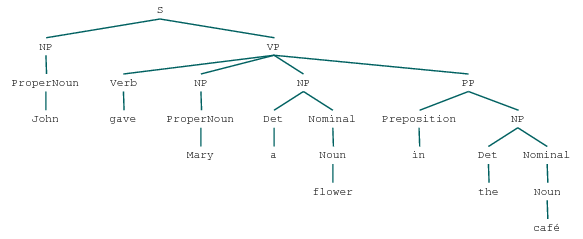

In [25]:
toy_parser = nltk.ChartParser(toy_grammar)
# the split() part is important
for tree in toy_parser.parse('John gave Mary a flower in the café'.split()):
    display(tree)

The parse returns an iterator of `nltk.tree.Tree` objects. This class has some useful functions, such as

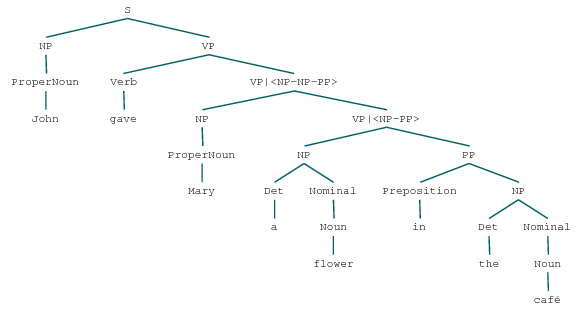

The tree has 2 children.
The first child is another tree: (NP (ProperNoun John))
All nonterminals are Trees. They have labels: VP
Terminals are just strings: John


In [7]:
# Converts the tree to CNF
tree.chomsky_normal_form()
display(tree)
# Let's convert it back...
tree.un_chomsky_normal_form()
print('The tree has', len(tree), 'children.')
print('The first child is another tree:', tree[0])
print('All nonterminals are Trees. They have labels:', tree[1].label())
print('Terminals are just strings:', tree[0][0][0])

Note that in `nltk`, one can convert a `Tree` to CNF, but not the whole grammar. Also, for full CNF conversion, one needs to run two functions:
- [`collapse_unary`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.collapse_unary). Usually with `collapsePOS=True`;
- [`chomsky_normal_form`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.chomsky_normal_form).

The function [`un_chomsky_normal_form`](http://www.nltk.org/api/nltk.html#nltk.tree.Tree.un_chomsky_normal_form) undoes both transformations.

As you can see, `nltk` has some strange design choices - another being their reliance on Tcl. If you run this notebook on a machine with Tcl installed, a nifty grammar editing tool will pop up if you run

In [8]:
nltk.app.rdparser()

### 2. Simple grammars

These exercises will help you acquaint yourself with writing context-free grammars. The exercises are not all natural language-related $-$ showing the universality of the formalism

#### 2.1 Palindrome

Write a grammar that accepts the following language: $L = \{\text{w}c\text{w}^\text{R} | \text{w}\in\{a,b\}^*\}$ ($\text{w}^\text{R} = \text{w}$ backwards).

**Note**: the simplest solution (with a single `S` nonterminal **will not work** because of a bug in `nltk.ChartParser`). Use more nonterminals.

[S -> A S A, S -> B S B, S -> 'c', A -> 'a', B -> 'b']


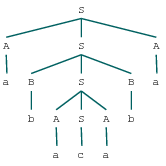

In [41]:
# Your solution here
pgr = nltk.CFG.fromstring("""
S -> A S A | B S B | 'c'
A -> 'a'
B -> 'b'
""")

pparser = nltk.ChartParser(pgr)
print(pgr.productions())

# Tests
assert pparser.parse_one('aca') is not None
assert pparser.parse_one('abc') is None
assert pparser.parse_one('aacba') is None

for tree in pparser.parse('abacaba'):
    display(tree)

#### 2.2 Restricted palindrome

The same as before, but `w` can at most be 3 characters long.

In [45]:
pgr = nltk.CFG.fromstring("""
S1 -> A S2 A | B S2 B | S2
S2 -> A S3 A | B S3 B | S3
S3 -> A 'c' A | B 'c' B | 'c'
A -> 'a'
B -> 'b'
""")

pparser = nltk.ChartParser(pgr)

# Tests
assert pparser.parse_one('aca') is not None
assert pparser.parse_one('bbcbb') is not None
assert pparser.parse_one('abacaba') is not None
assert pparser.parse_one('aacba') is None
assert pparser.parse_one('babacabab') is None

#### 2.3 Agreement

Not exactly linguistic agreement, but related. Find a Context-Free Grammar for the following language:
$L = \{\text{a}^n\text{b}^m\text{c}^k: n + m = k\}$

In [49]:
agr = nltk.CFG.fromstring("""
SA -> A SA C | SB | A C
SB -> B SB C | B C
A -> 'a'
B -> 'b'
C -> 'c'
""")

aparser = nltk.ChartParser(agr)

# Tests
assert aparser.parse_one('aabccc') is not None
assert aparser.parse_one('bc') is not None
assert aparser.parse_one('aacc') is not None
assert aparser.parse_one('aabc') is None
assert aparser.parse_one('abbbcccccc') is None
assert aparser.parse_one('bacc') is None

### 3. Arithmetics

#### 3.1 Basics
Model the four elementary mathematical operations, namely `+`, `-`, `*` and `/`. Your tasks is to validate mathematical expressions that use them. Specifically:
- single-digit numbers are valid expressions
- if `expr1` and `expr2` are valid expressions, these are also valid:
  - `expr1 + expr2`
  - `expr1 - expr2`
  - `expr1 * expr2`
  - `expr1 / expr2`
  - `(expr1)`
  
Try to solve it with as few nonterminals as possible.

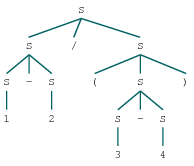

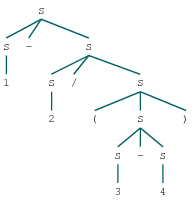

In [9]:
# Your solution here
agr = nltk.CFG.fromstring("""
S -> '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
S -> S '+' S
S -> S '-' S
S -> S '*' S
S -> S '/' S
S -> '(' S ')'
""")
aparser = nltk.ChartParser(agr)

for tree in aparser.parse('1 - 2 / ( 3 - 4 )'.split()):
    display(tree)

#### 3.2 Precedence

If you implemented the previous task with a single nonterminal, you will see that the grammar is undeterministic, and some parses do not reflect the precedence of mathematical operators. Fix the grammar so that it does!

Hints:
- `+` and `-` should be higher up the tree than `*` and `/`
- you will need at least 3 nonterminals
- allow chaining of the same operator types, e.g. `1 + 2 - 3`. One of the nonterminals in the toy grammar above does something similar
- do not worry about unit productions, but don't create a unit recursion cycle (e.g. `A -> B -> C -> A`)

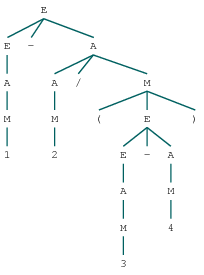

In [10]:
agr = nltk.CFG.fromstring("""
E -> E '+' A | E '-' A | A
A -> A '*' M | A '/' M | M
M -> '(' E ')'
M -> '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
""")

aparser = nltk.ChartParser(agr)

# Tests
for tree in aparser.parse('1 - 2 / ( 3 - 4 )'.split()):
    display(tree)
assert len(list(aparser.parse('1 - 2 + 3 / ( 4 - 5 )'.split()))) > 0

#### 3.3 CNF

Parse an expression and convert the resulting tree into CNF. If you succeed, congratulations, you can skip this exercise.

However, most likely the function will throw an exception. This is because the NLTK algorithm cannot cope with rules that mix nonterminals and terminals in certain ways (e.g. `A -> B '+' C`). Fix your grammar by introducing a POS-like nonterminal (e.g. `add` for `+`) into each such rule.

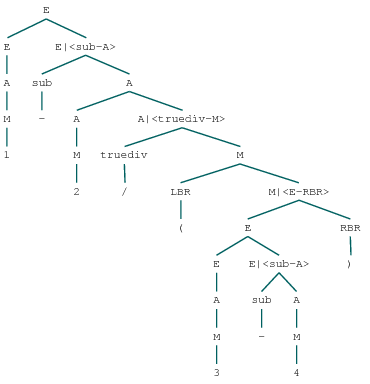

In [101]:
agr = nltk.CFG.fromstring("""
E -> E add A | E sub A | A
A -> A mul M | A truediv M | M
M -> LBR E RBR | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
add -> '+'
sub -> '-'
mul -> '*'
truediv -> '/'
LBR -> '('
RBR -> ')'
""")

aparser = nltk.ChartParser(agr)

tree = list(aparser.parse('1 - 2 / ( 3 - 4 )'.split()))[0]
tree.chomsky_normal_form()
display(tree)

#### 3.4 Evaluation*

Compute the value of the expression. Implement a recursive function that traverses the tree and returns an interger.

Note: if you implemented this function well, but get an `AssertionError` from the last line, it means that your grammar is probably right associative. Look at the (non-CNF) tree to confirm this. If so, make it left associative.

In [14]:
def evaluate_tree(tree):
    """Returns the value of the expression represented by tree."""
    import operator
    if len(tree) == 3:
        if tree.label() in ['E', 'A']:
            val = getattr(operator, tree[1].label())(
                evaluate_tree(tree[0]),
                evaluate_tree(tree[2])
            )
            return val
        else:  # M
            return evaluate_tree(tree[1])
    elif tree.label() == 'M':  # M
        return int(tree[0])
    else:
        return evaluate_tree(tree[0])

# Tests
assert evaluate_tree(next(aparser.parse('1+2'))) == 3
assert evaluate_tree(next(aparser.parse('1+2*3'))) == 7
assert evaluate_tree(next(aparser.parse('3/(2-3)-4/2-5'))) == -10

### 4. Treebanks

NLTK also contains corpora. Amongst others, it contains about 10% of the Penn TreeBank (PTB).

#### 4.1 Download

Download the corpus with the `nltk.download()` tool. It is under Corpora and is called `treebank`.

In [3]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /home/david/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

#### 4.2 Corpus statistics

The functions below can be used to get the file ids, words, sentences, parse trees from the treebank.

Using them, get the following following corpus statistics:
- the number of sentences
- number of words

Ids: ['wsj_0001.mrg', 'wsj_0002.mrg', 'wsj_0003.mrg', 'wsj_0004.mrg', 'wsj_0005.mrg', 'wsj_0006.mrg', 'wsj_0007.mrg', 'wsj_0008.mrg', 'wsj_0009.mrg', 'wsj_0010.mrg', 'wsj_0011.mrg', 'wsj_0012.mrg', 'wsj_0013.mrg', 'wsj_0014.mrg', 'wsj_0015.mrg', 'wsj_0016.mrg', 'wsj_0017.mrg', 'wsj_0018.mrg', 'wsj_0019.mrg', 'wsj_0020.mrg', 'wsj_0021.mrg', 'wsj_0022.mrg', 'wsj_0023.mrg', 'wsj_0024.mrg', 'wsj_0025.mrg', 'wsj_0026.mrg', 'wsj_0027.mrg', 'wsj_0028.mrg', 'wsj_0029.mrg', 'wsj_0030.mrg', 'wsj_0031.mrg', 'wsj_0032.mrg', 'wsj_0033.mrg', 'wsj_0034.mrg', 'wsj_0035.mrg', 'wsj_0036.mrg', 'wsj_0037.mrg', 'wsj_0038.mrg', 'wsj_0039.mrg', 'wsj_0040.mrg', 'wsj_0041.mrg', 'wsj_0042.mrg', 'wsj_0043.mrg', 'wsj_0044.mrg', 'wsj_0045.mrg', 'wsj_0046.mrg', 'wsj_0047.mrg', 'wsj_0048.mrg', 'wsj_0049.mrg', 'wsj_0050.mrg', 'wsj_0051.mrg', 'wsj_0052.mrg', 'wsj_0053.mrg', 'wsj_0054.mrg', 'wsj_0055.mrg', 'wsj_0056.mrg', 'wsj_0057.mrg', 'wsj_0058.mrg', 'wsj_0059.mrg', 'wsj_0060.mrg', 'wsj_0061.mrg', 'wsj_0062.mrg', 'w

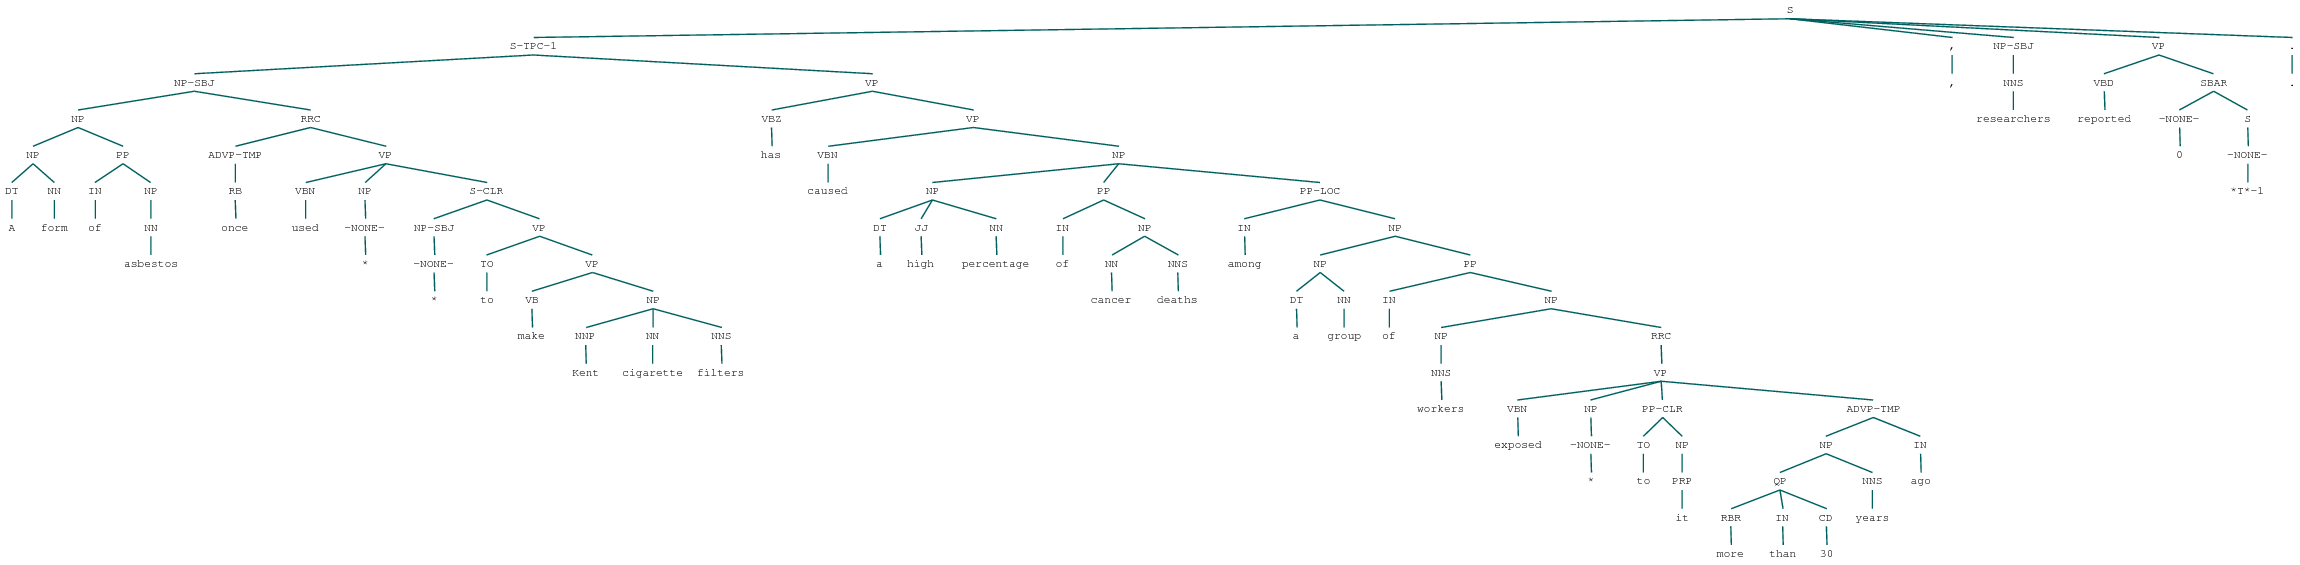

In [4]:
from nltk.corpus import treebank

# PTB file ids
print('Ids:', treebank.fileids())

# Words in one of the files
print('Words:', treebank.words('wsj_0003.mrg'))

# Word - POS-tag pairs
print('Tagged words:', treebank.tagged_words('wsj_0003.mrg'))

display(treebank.parsed_sents('wsj_0003.mrg')[0])

#### 4.3 POS statistics

Using the output of `tagged_words()`, above, create two dictionaries:
- `pos_words`: POS tag $\rightarrow$ words
- `word_poss`: word $\rightarrow$ POS tags

With the help of these dictionaries, compute the following statistics:
- number of word types
- number of POS tags
- which POS tag has the most word types
- which word has the most POS tags assigned to it

**Note**:
- use all the files
- don't forget to lowercase the words
- `defaultdict` might be useful...

In [20]:
from collections import defaultdict
from operator import itemgetter

pos_word = defaultdict(set)
word_pos = defaultdict(set)
for file_id in treebank.fileids():
    for Word, POS in treebank.tagged_words(file_id):
        word = Word.lower()
        pos_word[POS].add(word)
        word_pos[word].add(POS)
        
word_types = len(word_pos)
pos_tags = len(pos_word)
most_frequent_pos = sorted(pos_word.items(), key=lambda pw: len(pw[1]), reverse=True)[0][0]
word_with_most_pos = sorted(word_pos.items(), key=lambda wp: len(wp[1]), reverse=True)[0][0]

print('Number of word types:', word_types)
print('Number of POS tags:', pos_tags)
print('Most frequent POS tag:', most_frequent_pos)
print('Word type with most POS tags:', word_with_most_pos)

# Tests
assert word_types == 11387
assert pos_tags == 46
assert most_frequent_pos == 'NN'
assert word_with_most_pos == 'a'

Number of word types: 11387
Number of POS tags: 46
Most frequent POS tag: NN
Word type with most POS tags: a
